# Leitor de código de barras 1D

In [23]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

## Carregando código de barras


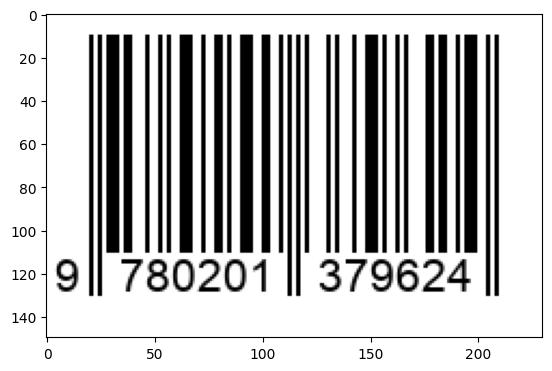

In [24]:
img = io.imread("dcode-image (17).png")
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

## Convertendo para a escala de cinza

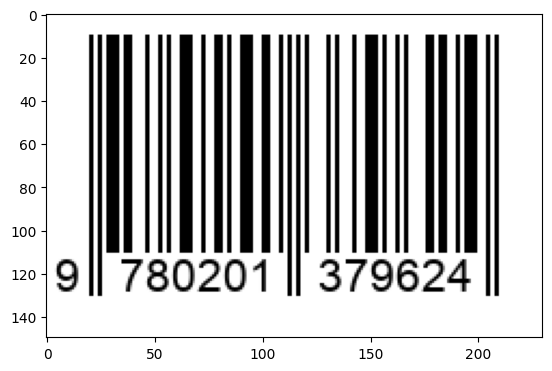

In [25]:
# convertendo p/ escala de cinza
if img.shape[-1] == 4:
    gray = color.rgba2rgb(img)
    gray = color.rgb2gray(gray) * 255
else:
    gray = color.rgb2gray(img) * 255
gray = gray.astype(np.uint8)

plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

## Binarizando a imagem

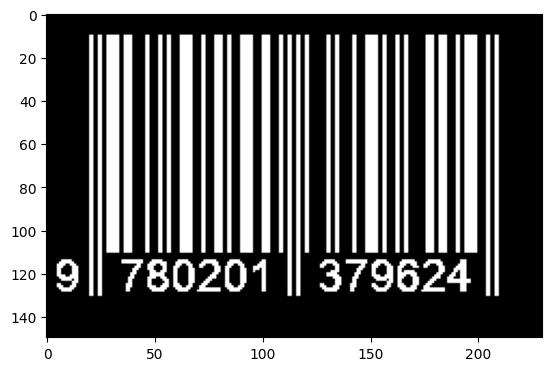

In [26]:
# binarizando c/ limiar fixo
limiar = 200  
imgBin = np.where(gray > limiar, 255, 0).astype(np.uint8)

# invertendo as cores
imgBin = 255 - imgBin

plt.imshow(imgBin, cmap='gray', vmin=0, vmax=255)

## Tratando a linha central

In [27]:
# extraindo linha do meio
linha = imgBin[int(img.shape[0]/2), :]

# convertendo p 0s e 1s
linha = np.where(linha == 255, 1, 0)

## Reconhecendo o padrão de barras da imagem

In [28]:
# agrupando as sequencias de 1s e 0s
def leitorBarras(linha):
    barras = []
    tamAtual = 1
    for i in range(len(linha)-1):
        if linha[i] == linha[i+1]:
            tamAtual = tamAtual + 1
        else:
            barras.append(tamAtual * str(linha[i]))
            tamAtual = 1
    barras.pop(0)
    return barras

## Detectando tamanho do módulo
A quantidade de pixeis entre as barras é considerado um módulo.

In [29]:
# detecta o menor comprimento entre as barras e considera como o tamanho do modulo
def detectarTamModulo(barras):
    tam = len(barras[0])
    for barra in barras:
        tam = min(len(barra),tam)
    return tam
    
tamModulo = detectarTamModulo(leitorBarras(linha))
print("Tamanho do módulo:", tamModulo)

Tamanho do módulo: 2


## Convertendo o array para uma String
Realizado a partir do módulo.

In [30]:
# convertendo o array p uma string, onde tudo depende do tamanho do modulo
def arrayToString(array, tamModulo):
     s = ""
     for value in array:
         s = s + str(value)
     s=s.replace("1"*tamModulo,"1")
     s=s.replace("0"*tamModulo,"0")
     print("String:" + s)
     return s
        
dados = arrayToString(linha,tamModulo)

String:0000000000101011101100010010100111001001101001110011001010101000010100010011101001010000110110010111001010000000000


## Definindo as tabelas de Patterns

In [31]:
# patterns de codificação
leftOdd = {
    '0': '0001101',
    '1': '0011001',
    '2': '0010011',
    '3': '0111101',
    '4': '0100011',
    '5': '0110001',
    '6': '0101111',
    '7': '0111011',
    '8': '0110111',
    '9': '0001011'
}

leftEven = {
    '0': '0100111',
    '1': '0110011',
    '2': '0011011',
    '3': '0100001',
    '4': '0011101',
    '5': '0111001',
    '6': '0000101',
    '7': '0010001',
    '8': '0001001',
    '9': '0010111'
}

right = {
    '0': '1110010',
    '1': '1100110',
    '2': '1101100',
    '3': '1000010',
    '4': '1011100',
    '5': '1001110',
    '6': '1010000',
    '7': '1000100',
    '8': '1001000',
    '9': '1110100'
}

# buscando o digito correspondente a um cod bin
oddReverso = {v: k for k, v in leftOdd.items()}
evenReverso = {v: k for k, v in leftEven.items()}
rightReverso = {v: k for k, v in right.items()}

# pattern de paridade para determinar o 1° digito
paridade = {
    'AAAAAA': '0',
    'AABABB': '1',
    'AABBAB': '2',
    'AABBBA': '3',
    'ABAABB': '4',
    'ABBAAB': '5',
    'ABBBAA': '6',
    'ABABAB': '7',
    'ABABBA': '8',
    'ABBABA': '9'
}

## Função de decodificação do código de barras para o Ean13

In [32]:
# decodificando a string p padrão ean13
def decodificar(dados):
    # encontrando a marcação inicial (left guard)
    marcEsqInicial = dados.find('101')
    if marcEsqInicial == -1:
        print("Deu erro: Marcação inicial")

    # marcacao inicial
    fimMarcEsqInicial = marcEsqInicial + 3
    # filtrando apenas a parte esquerda
    parteEsq = dados[fimMarcEsqInicial : fimMarcEsqInicial + 42]
    #encontrando o inicio da marcacao do meio
    inicioMarcMeio = fimMarcEsqInicial + 42
    # definindo marcMeio
    marcMeio = dados[inicioMarcMeio : inicioMarcMeio +5]
    
    if marcMeio != '01010':
        print("Deu erro: Marcação do meio")

    # semelhante ao anterior    
    inicioParteDir = inicioMarcMeio +5
    parteDir = dados[inicioParteDir : inicioParteDir +42]
    inicioMarcDir = inicioParteDir +42
    marcDir = dados[inicioMarcDir : inicioMarcDir +3]
    
    if marcDir != '101':
        print("Deu erro: Marcação direita")

    # divindo em codigos/segmentos de 7 bits
    codEsq = [parteEsq[i*7:(i+1)*7] for i in range(6)]
    codDir = [parteDir[i*7:(i+1)*7] for i in range(6)]

    # verificando se cada codigo pertence a tabela A ou B e registro o padrão de paridade
    patternParidade = []
    digEsq = []
    for code in codEsq:
        if code in oddReverso:
            patternParidade.append('A')
            digEsq.append(oddReverso[code])
        elif code in evenReverso:
            patternParidade.append('B')
            digEsq.append(evenReverso[code])
        else:
            print("Deu erro: Paridade")

    # determinando primeiro dígito pelo pattern de paridade
    paridade_str = ''.join(patternParidade)
    digInicial = paridade.get(paridade_str, None)

    # decodificando a tabela direita
    digDir = []
    for code in codDir:
        if code in rightReverso:
            digDir.append(rightReverso[code])
        else:
            print("Deu erro: dígitos direito")
    
    # unindo tudo
    codEan = digInicial + ''.join(digEsq) + ''.join(digDir)
    
    # validando checksum
    dig = [int(c) for c in codEan]
    somaImpar = sum(dig[i] for i in range(0, 12, 2))
    somaPar = sum(dig[i] for i in range(1, 12, 2))
    total = somaImpar + 3 * somaPar
    checksum = (10 - (total % 10)) % 10
    
    if checksum != dig[-1]:
        print("Deu erro: Checksum")
    
    
    return codEan



## Resultado:

In [33]:
ean13 = decodificar(dados)
print("Cod Ean13: ", ean13)

Cod Ean13:  9780201379624
